<a href="https://colab.research.google.com/github/dkapitan/jads-nhs-proms/blob/master/notebooks/2.0-data-understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Understanding

This is day 1 from the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/outline.md).



## Learning objectives: descriptive statistics
- Explore Y
- Define Y with results exploration combined with clinical knowledge
- Assess missing values
- Assess data structure
- Explore correlation plot (X, Y)

## Learning objectives: Python
- [Using pandas to explore data](https://realpython.com/pandas-python-explore-dataset/)
- [Fundamental stats to describe your data](https://realpython.com/python-statistics/)
- [Reading and writing files with pandas](https://realpython.com/pandas-read-write-files/)
- Be aware of some `pandas` pitfalls:
  - Know how `pandas` uses copies by default and good practice not to replace in-place
  - Use Int64 for N/A


## Business understanding
Assume that primary reasons to replace a knee is to **i) reduce pain**, and **ii) improve daily functioning**. The dataset contains the various patient-reported outcome measures that can be used to measure the outcome along these two dimenions:
- Oxford Knee Score (OKS): a 12-item questionnaire that assess daily functioning c.q. disability due to knee osteoarthritis. Items are scored from [0,4], where higher is better (no disability).  
  - OKS question on pain and night pain, both on scale from [0,4]
  - OKS , higher is better. The OKS is a 12-item questionaire that assess daily functioning c.q. disability.
- EQ5D: generic quality of life PROMs along 5 dimensions on a 3-point Likert scale [1,3], lower is better. Dimensions are problems activity, anxiety, discomfort, mobility and self-care.
- EQ-VAS: general reported health on a scale from [0,100], higher is better.

We will explore the PROMs data to see which target variable Y is meaningful to assess the outcome of knee replacement. Note PROMs are measured at T0 (prior to surgery) and T1 (six months after surgery).
    

# Showing basic statistics


## Getting started with pandas

In [0]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model


# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# contants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

In [0]:
# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# alternatively, if you have cloned this repository, read local file
# df = pd.read_parquet('../data/interim/knee-provider.parquet')

## Displaying data types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139236 entries, 0 to 47603
Data columns (total 81 columns):
provider_code                   139236 non-null object
procedure                       139236 non-null object
revision_flag                   139236 non-null uint8
year                            139236 non-null object
age_band                        129834 non-null object
gender                          129834 non-null float32
t0_assisted                     139236 non-null uint8
t0_assisted_by                  139236 non-null uint8
t0_symptom_period               139236 non-null uint8
t0_previous_surgery             139236 non-null uint8
t0_living_arrangements          139236 non-null uint8
t0_disability                   139236 non-null uint8
heart_disease                   139236 non-null uint8
high_bp                         139236 non-null uint8
stroke                          139236 non-null uint8
circulation                     139236 non-null uint8
lung_disease        

## Describing the data and setting options for pandas

In [4]:
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revision_flag,139236.0,0.04,0.19,0.00,0.00,0.00,0.00,1.00
gender,129834.0,1.57,0.49,1.00,1.00,2.00,2.00,2.00
t0_assisted,139236.0,1.92,0.82,1.00,2.00,2.00,2.00,9.00
t0_assisted_by,139236.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t0_symptom_period,139236.0,2.65,1.05,1.00,2.00,2.00,3.00,9.00
t0_previous_surgery,139236.0,1.97,0.67,1.00,2.00,2.00,2.00,9.00
t0_living_arrangements,139236.0,1.35,1.04,1.00,1.00,1.00,1.00,9.00
t0_disability,139236.0,1.81,1.59,1.00,1.00,2.00,2.00,9.00
heart_disease,139236.0,8.25,2.33,1.00,9.00,9.00,9.00,9.00
high_bp,139236.0,5.46,3.97,1.00,1.00,9.00,9.00,9.00


### First selection Y

In [5]:
proms = ['oks_t0_score', 'oks_t1_score', 'oks_t0_pain', 'oks_t1_pain', 'oks_t0_night_pain', 'oks_t1_night_pain', 't0_discomfort', 't1_discomfort', 't0_eq_vas', 't1_eq_vas', ]
df.loc[:,proms].describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
oks_t0_score,137567.0,19.0,7.7,0.0,13.0,19.0,24.0,48.0
oks_t1_score,136657.0,35.9,9.5,0.0,30.0,38.0,43.0,48.0
oks_t0_pain,139236.0,0.6,0.7,0.0,0.0,0.0,1.0,9.0
oks_t1_pain,139236.0,2.7,1.3,0.0,2.0,3.0,4.0,9.0
oks_t0_night_pain,139236.0,1.3,1.4,0.0,0.0,1.0,2.0,9.0
oks_t1_night_pain,139236.0,2.9,1.3,0.0,2.0,3.0,4.0,9.0
t0_discomfort,139236.0,2.6,1.4,1.0,2.0,2.0,3.0,9.0
t1_discomfort,139236.0,1.9,1.3,1.0,1.0,2.0,2.0,9.0
t0_eq_vas,139236.0,154.0,271.4,0.0,55.0,75.0,89.0,999.0
t1_eq_vas,139236.0,118.2,196.4,0.0,69.0,80.0,90.0,999.0


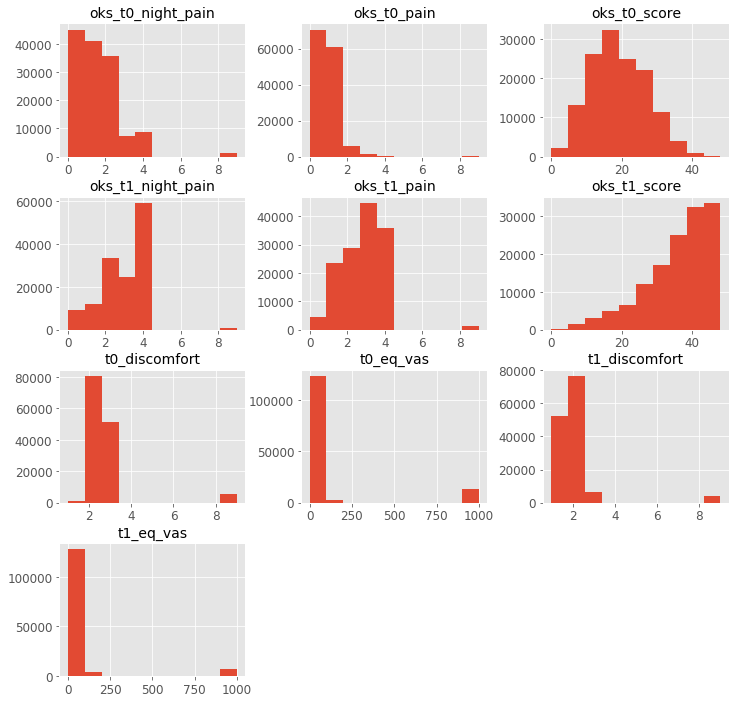

In [6]:
# inspect with histograms
df.loc[:,proms].hist(figsize=M);

## Missing values and sentinel values
The histogram shows that `9` and `999` are used as [sentinel values](https://en.wikipedia.org/wiki/Sentinel_value) for missings.

In [7]:
df.loc[:,['t0_eq_vas', 't1_eq_vas']].apply(pd.value_counts).tail()

,t0_eq_vas,t1_eq_vas
97,391,882
98,444,1015
99,332,618
100,2707,4261
999,12961,6546


In [8]:
_no9 = [col for col in df.columns if col.startswith('oks_t') and not col.endswith('score')]
df.loc[:,_no9].apply(pd.value_counts)

,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t1_pain,oks_t1_night_pain,oks_t1_washing,oks_t1_transport,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs
0,70493,45021,810,740,17037,4765,60433,60103,18286,18877,24162,7612,4638,8955,356,360,3963,501,6235,42702,2484,1707,9043,3232
1,60701,40943,12189,31896,17499,59989,47425,48650,59140,40686,27235,46072,23471,12180,2283,5909,5110,7965,10319,23453,8443,4511,6134,8740
2,6171,35851,43630,72115,56402,50796,16080,24326,47021,32501,46012,58010,28987,33555,12700,32345,14790,23588,10525,30319,25129,7807,16628,26724
3,1340,7380,38234,23997,35763,19684,12158,4022,11494,35050,26975,21349,44799,24498,25157,46526,30372,53884,50910,30361,45873,34264,27699,42941
4,333,8737,44248,9138,11092,2549,1725,739,1939,10780,13509,4855,36051,59171,97502,52859,83740,52292,60150,11310,56295,90000,78727,56619
9,198,1304,125,1350,1443,1453,1415,1396,1356,1342,1343,1338,1290,877,1238,1237,1261,1006,1097,1091,1012,947,1005,980


### Replacing missing or sentinel values
Up to now, pandas used several values to represent missing data: `np.nan` is used for this for float data, `np.nan` or `None` for object-dtype data and `pd.NaT` for datetime-like data. An experimental, new `pandas.NA` feature is introduced in version 1.0. Note that Google Colab still uses version 0.25 (as of 2020-03-15).

`.loc` and `.iloc` are the recommended way to access parts of a `pd.DataFrame`. Note that this **always returns as copy**. Hence, to replace values, best practice is to:
- make a new copy
- do the replacements in the copy with explicit assignment

Note that [pandas can handle missing values in integer columns recently](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html) (since version 0.24). This is still experimental, so be aware! Your options for handling missing values in integer columns are:
- Convert to `float64`, which is the most robust, old way to do it
- Convert to the new `Int64` dtype (note the capital `I`!)




In [9]:
# This DOES NOT work
df.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64').dtypes
df.loc[:,['t0_eq_vas', 't1_eq_vas']].head()

,t0_eq_vas,t1_eq_vas
0,80,999
1,999,95
2,999,98
3,999,60
4,75,80


In [10]:
# when using iloc or loc you need to specify a location to update with some value.
# explicitly make new copy
dfc = df.copy()
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']] = dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64')
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].head()

,t0_eq_vas,t1_eq_vas
0,80,NaN
1,NaN,95
2,NaN,98
3,NaN,60
4,75,80


In [11]:
# simarly, change 9 to N/A for OKS
dfc.loc[:,_no9] = df.loc[:,_no9].replace(9, np.nan).astype('Int64')
pd.concat([df.loc[:,_no9].isnull().sum(), dfc.loc[:,_no9].isnull().sum()], axis=1, keys=['df', 'dfc'])

,df,dfc
oks_t0_pain,0,198
oks_t0_night_pain,0,1304
oks_t0_washing,0,125
oks_t0_transport,0,1350
oks_t0_walking,0,1443
oks_t0_standing,0,1453
oks_t0_limping,0,1415
oks_t0_kneeling,0,1396
oks_t0_work,0,1356
oks_t0_confidence,0,1342


# Explore (X, Y)

In [24]:
# we are just going to drop all NAs
dfc.dropna(inplace=True)
print(f'Raw data:   {df.shape[0]} rows\nNo NA data: {dfc.shape[0]} rows\n # dropped:  {df.shape[0] - dfc.shape[0]} rows')

Raw data:   139236 rows
No NA data: 103486 rows
 # dropped:  35750 rows


## Volume per provider per year

In [13]:
# count number of providers
dfc.provider_code.unique().shape

(294,)

In [14]:
# volume per provider per year
volume_provider_year = dfc.groupby(['year', 'provider_code'])['procedure'].count().unstack()
volume_provider_year.iloc[:,0:20]

provider_code,ADP02,AHH,AVQ,NFH01,NN401,NN801,NQM01,NT202,NT204,NT205,NT206,NT209,NT210,NT211,NT212,NT213,NT214,NT215,NT218,NT219
year,,,,,,,,,,,,,,,,,,,,
2016/17,164.0,24.0,NaN,NaN,12.0,33.0,NaN,18.0,60.0,9.0,23.0,49.0,84.0,NaN,16.0,214.0,78.0,153.0,18.0,82.0
2017/18,236.0,30.0,NaN,NaN,7.0,43.0,10.0,22.0,75.0,6.0,28.0,62.0,73.0,17.0,50.0,335.0,112.0,11.0,27.0,94.0
2018/19,323.0,16.0,139.0,13.0,22.0,66.0,12.0,28.0,106.0,16.0,65.0,65.0,72.0,13.0,76.0,403.0,127.0,9.0,32.0,91.0


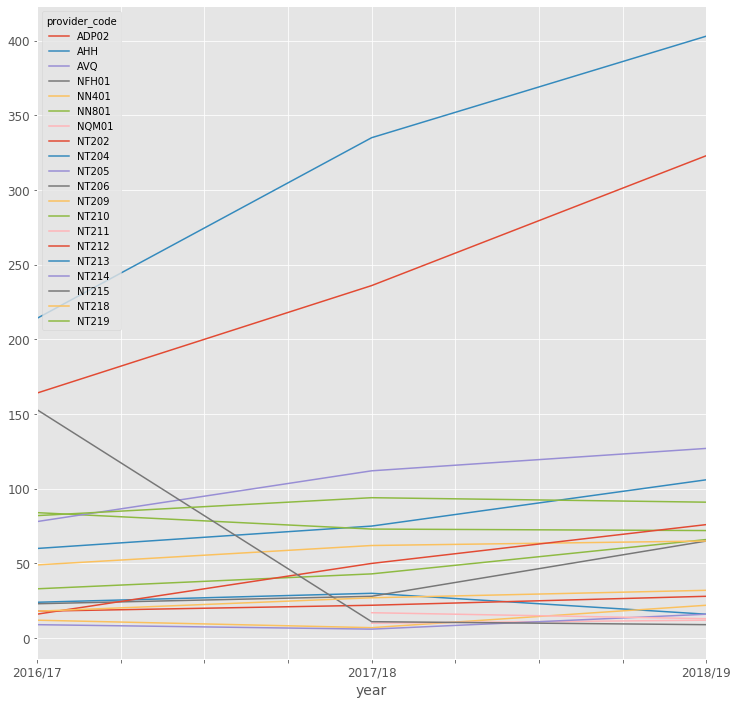

In [15]:
# first 20 providers in the data
volume_provider_year.iloc[:,0:20].plot(figsize=M);

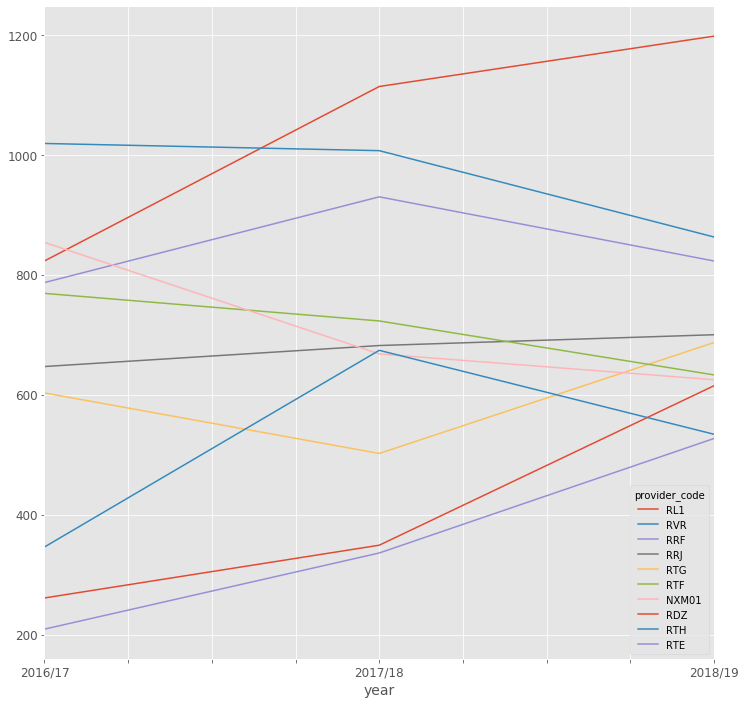

In [16]:
# select 10 largest providers by 2018/19
_year = (dfc.year == '2018/19')
top10 = dfc.loc[_year,:].groupby('provider_code').count()['procedure'].sort_values(ascending=False).head(10)
volume_provider_year.loc[:, list(top10.index)].plot(figsize=M);

## Y = Improvement in Oxford Knee Score

In [26]:
# add delta_oks_score
dfc['delta_oks_score'] = dfc.oks_t1_score - dfc.oks_t0_score

0

### Y by provider, year (using boxplots)

In [18]:
# calculate descriptive stats for delta_oks
dfc.groupby(['year', 'provider_code'])['delta_oks_score'].describe().head()

count   mean    std   min    25%   50%   75%   max
year    provider_code                                                    
2016/17 ADP02          161.0  17.09   9.31 -10.0  12.00  17.0  23.0  41.0
        AHH             23.0  17.39  13.19 -18.0  10.00  18.0  24.5  43.0
        NN401           12.0  18.17   8.30   0.0  16.00  19.5  22.0  33.0
        NN801           33.0  14.09  10.05  -5.0   9.00  15.0  22.0  33.0
        NT202           18.0  13.50  10.46 -21.0  11.25  14.0  21.0  24.0

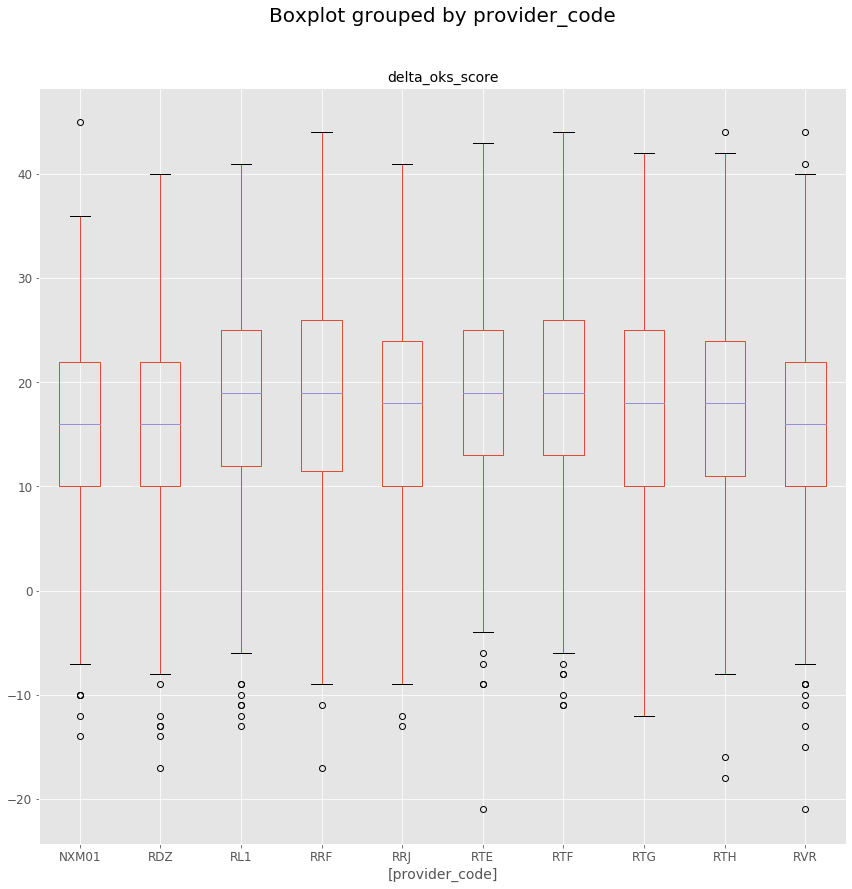

In [19]:
_top10_latest = (dfc.provider_code.isin(top10.index)) & (dfc.year=='2018/19')
dfc.loc[_top10_latest,['provider_code', 'delta_oks_score']].boxplot(by=['provider_code'], figsize=L);

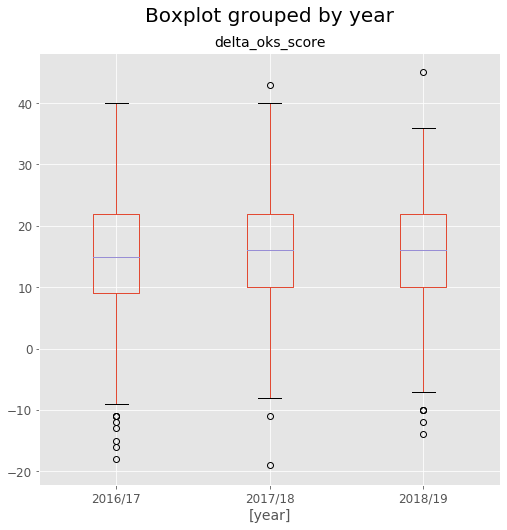

In [20]:
# lets look at a single provider and see whether delta_oks_score changes year-on-year
dfc.loc[(dfc.provider_code.isin(['NXM01'])),['year', 'delta_oks_score']].boxplot(by=['year'], figsize=S);

In [0]:
# group providers in 10 deciles by volume
provider_cat = pd.qcut(volume_provider_year.loc['2018/19',:], q=10)

### Y by casemix variables (using Chi Square test)
Usually casemix attributes are strong predictors for outcomes. With chi-squared test we can assess which categorical variables have strong associations. Note that the casemix indicators are encoded with 1 (present) or 9 (missing).

In [34]:
casemix = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
chi2_, pval = chi2(dfc.loc[:,casemix], dfc.delta_oks_score)
chi = pd.DataFrame({'feature': casemix, 'chi2': chi2_, 'p': pval}).sort_values('chi2', ascending=False)
chi

,feature,chi2,p
11,arthritis,525.36,4.20e-67
1,high_bp,234.30,2.67e-17
5,diabetes,204.44,4.59e-13
10,depression,199.45,2.18e-12
3,circulation,142.64,1.53e-05
0,heart_disease,85.62,2.86e-01
4,lung_disease,55.43,9.80e-01
9,cancer,22.96,1.00e+00
6,kidney_disease,12.17,1.00e+00
2,stroke,10.19,1.00e+00


## Scatter matrix


In [23]:
# 3-point scales don't look that interesting, let's zoom in on oks_score and eq_vas
# note some functions don't work with nullable integer Int64 (yet), so converting back to int64
oks_vas = ['oks_t0_score', 'oks_t1_score', 't0_eq_vas', 't1_eq_vas']
pd.plotting.scatter_matrix(dfc.loc[:,oks_vas].astype('int64'), figsize=L, alpha=0.2);

ValueError: ignored

## Correlation plots

# Concluding remarks

## Other things to look into
* do infeasible combinations of variable values occur in the data (e.g. minors with a drivers license or pregnant males)? 
* a tree-model where Y is being predicted using a cluster of related X-variables, such as ROM-items
* which variables are known / not known at the point of prediction?
* which domains (work, health, family, lifestyle, therapy, etc etc) are covered?


## Checklist for results from data understanding process
* assessment of the quality of the data (in terms of outliers and missings)
* input regarding the moment of prediction
* input for data cleaning (handling missing data; removing variables not known at time of prediction, near-zero variance variables, etc)
* input for feature engineering (adjusting variables based on tree-analyses, based on correlations, based on domain-analysis)
* input for defining the outcome variable Y
* input for defining the project in terms of generalizability (in case of missing Y values)
* input for choosing the project in case there are still multiple options at the table
* input for defining the scope of the project (e.g. limiting to a subgroup to get a better balanced outcome variable)
* a potential revision of the goal of your project
* input for which variables and combination of variables seem particularly relevant within the to-be-developed algorithms 

In [0]:
---
title: "Data Exploration"
---
###### Joran Lokkerbol; sept 2019

```{r}
knitr::opts_chunk$set(echo = TRUE)
options(scipen=999)
```

```{r}
#install.packages("rmarkdown")
#install.packages("psych")
#install.packages("ggplot2")
#install.packages("summarytools")
#install.packages("corrplot")
#install.packages("purrr")
#install.packages("tidyr")
#install.packages("caret")
#install.packages("rpart")
#install.packages("rpart.plot")
#install.packages("rattle")
#install.packages("dplyr")
#install.packages("DescTools")
library(rmarkdown)
library(psych)
library(ggplot2)
library(corrplot)
library(purrr)
library(tidyr)
library(caret)
library(rpart)
library(rpart.plot)
library(rattle)
library(dplyr)
library(DescTools)
rm(list = ls())  # Delete everything that is in R's memory
setwd("/Users/joranlokkerbol/Documents/ML-institute/content - opleiding/dag1/")
dataset <- read.csv("student-por.csv", header = TRUE)
dataset <- as.data.frame(dataset)
class(dataset)
```




## Describing the data (general)

```{r}
#View(dataset)
str(dataset)
describeFast(dataset)
dataset %>%
  keep(is.numeric) %>% describe
#suppressWarnings(print(dfSummary(dataset), method = 'render', silent=TRUE))
# map the number of missings
sapply(dataset, function(x) sum(is.na(x))) 
# map levels and frequencies per categorical variable
temp <-  dataset %>% keep(is.factor)
for (i in 1:ncol(temp)) {
        print(names(temp[i]))
        print(Freq(temp[,i]))}
```

## Histrograms per variable to check distribution and outliers
```{r}
dataset %>%
  keep(is.numeric) %>%
  gather() %>%
  ggplot(aes(value)) +
  facet_wrap(~ key, scales = "free") +
  geom_histogram()
```


## Identify near-zero variances predictors
```{r}
nearZeroVar(dataset, saveMetrics = TRUE)
```


## Exploring the outcome Y

```{r}
##### SET Y #######
dataset$Y <- dataset$health ## set Y
dataset <- subset(dataset, select=-c(health)) ### delete "health" to prevent duplicates
##### describe Y #####
plot(dataset$Y)
table(dataset$Y)
summary(dataset$Y)
boxplot(dataset$Y)
histogram(dataset$Y)
plot.ecdf(dataset$Y)
sum(is.na(dataset$Y)) #nr of missings affect generalizability of your model
# define Y as a binary variable
dataset$Y[dataset$Y < 3.5] <- 0
dataset$Y[dataset$Y >= 3.5] <- 1
table(dataset$Y)
```


## Correlation matrix
```{r}
res <- cor(dataset[unlist(lapply(dataset, is.numeric))])
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)
```

## Scatterplots to check for (non-)linear relations
```{r}
temp <- dataset %>% keep(is.numeric)
a <- ncol(temp)
b <- a/2
pairs(Y~.,data=temp[,c(1:b,a)], main="Scatterplot Matrix")
pairs(Y~.,data=temp[,c((b+1):a)], main="Scatterplot Matrix")
```



## Boxplots of categorical variables and Y 
```{r}
bp <- dataset[unlist(lapply(dataset, is.factor))]
bp$Y <- as.numeric(dataset$Y)
 for(k in 1:ncol(bp)){
 print(names(bp[k]))
   boxplot(bp$Y ~ bp[, k])
  #ggplot(bp, aes(x=bp[,k], y=bp$Y)) + 
#  geom_boxplot()
}
```

## Chi-square tests of categorical variables with Y
```{r}
cs <- dataset[unlist(lapply(dataset, is.factor))]
cs$Y <- dataset$Y
 for(k in 1:(ncol(cs)-1)){
 print(names(cs[k]))
 print(chisq.test(cs$Y, cs[, k]), correct = FALSE)
  #ggplot(bp, aes(x=bp[,k], y=bp$Y)) + 
#  geom_boxplot()
}
```

## Simple regression tree with all predictors and Y
```{r}
tree <- rpart(Y~., data = dataset)
rpart.plot(tree)
```

## Simple regression tree for all predictors separately and Y
```{r}
## Rpart or every single x and y 
for(i in 1:ncol(dataset)){
print(names(dataset)[i])
tree <- rpart(Y~dataset[,i], data = dataset)
rpart.plot(tree)   }
```
## Regression tree for a set of correlated predictors on Y
```{r}
temp <- select(dataset, Y, G1, G2, G3)
tree <- rpart(Y~., data = temp)
rpart.plot(tree)
```
